# Lineup a 1-D peak : scan detector *v* motor

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

TODO:

## Start the `instrument` package

In [1]:
from instrument.collection import *

I Wed-21:35:16 - ############################################################ startup
I Wed-21:35:16 - logging started
I Wed-21:35:16 - logging level = 10
I Wed-21:35:16 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/collection.py
I Wed-21:35:16 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Wed-21:35:17 - #### Bluesky Framework ####
I Wed-21:35:17 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Wed-21:35:17 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Wed-21:35:21 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/initialize.py
I Wed-21:35:27 - using databroker catalog 'class_2021_03'
I Wed-21:35:27 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/metadata.py
I Wed-21:35:27 - #### Devices ####
I Wed-21:35:27 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/area_detector.py
I Wed-21:35:27 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/calculation_records.py
I Wed-21:35:31 - /home/beams1/JEMIAN/Documents/projects/BCDA-APS/bluesky_instrument

work in progress

In [2]:
sd.monitors.append(temperature)



Transient Scan ID: 42823     Time: 2021-02-24 21:35:34
Persistent Unique Scan ID: '80af9ace-c908-4bde-8d42-0cba288314c6'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 21:35:37.7 |   -2.00000 |    0.01971 |
|         2 | 21:35:38.2 |   -1.82000 |    0.02294 |
|         3 | 21:35:38.7 |   -1.64000 |    0.02869 |
|         4 | 21:35:39.2 |   -1.45000 |    0.03561 |
|         5 | 21:35:39.7 |   -1.27000 |    0.04663 |
|         6 | 21:35:40.3 |   -1.09000 |    0.06231 |
|         7 | 21:35:40.8 |   -0.91000 |    0.09036 |
|         8 | 21:35:41.3 |   -0.73000 |    0.13493 |
|         9 | 21:35:41.8 |   -0.55000 |    0.22141 |
|        10 | 21:35:42.3 |   -0.36000 |    0.49441 |
|        11 | 21:35:42.8 |   -0.18000 |    1.50409 |
|        12 | 21:35:43.3 |    0.00000 |   32.15727 |
|  

('80af9ace-c908-4bde-8d42-0cba288314c6',
 '60d174c5-13bb-4d7a-82c0-4b207a26b59f')

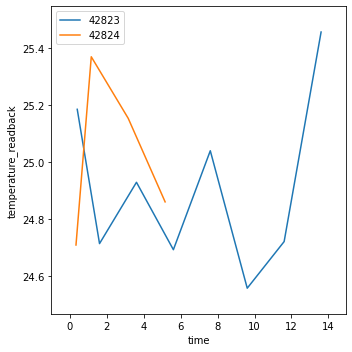

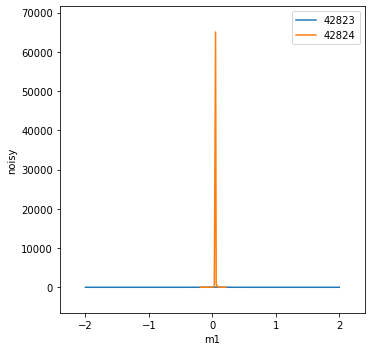

In [3]:
RE(example1())



Transient Scan ID: 42825     Time: 2021-02-24 21:35:58
Persistent Unique Scan ID: '663cebb5-a79f-4d04-93ad-97959f4678f3'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 21:36:00.9 |   -2.10000 |    0.01757 |
|         2 | 21:36:01.4 |   -1.91000 |    0.02122 |
|         3 | 21:36:01.9 |   -1.72000 |    0.02612 |
|         4 | 21:36:02.4 |   -1.53000 |    0.03265 |
|         5 | 21:36:02.9 |   -1.34000 |    0.04186 |
|         6 | 21:36:03.4 |   -1.15000 |    0.05549 |
|         7 | 21:36:03.9 |   -0.95000 |    0.08229 |
|         8 | 21:36:04.4 |   -0.76000 |    0.12492 |
|         9 | 21:36:04.9 |   -0.57000 |    0.20732 |
|        10 | 21:36:05.4 |   -0.38000 |    0.44559 |
|        11 | 21:36:05.9 |   -0.19000 |    1.37278 |
|        12 | 21:36:06.4 |    0.00000 |   32.52124 |
|  

I Wed-21:36:25 - iterative results:
======= ===================== ===================
scan_id center                FWHM               
======= ===================== ===================
42825   0.0047556017150934896 0.20777771426586295
42826   0.056085967445605955  0.03004201221203775
42827   0.05000841154458157   0.01012343511480647
42828   0.050008224612536865  0.01009830801751578
======= ===================== ===================



('663cebb5-a79f-4d04-93ad-97959f4678f3',
 'a4c4620d-8e58-4b91-9565-2d39af40c6e0',
 '2bd8c4c3-aed6-4be8-9f92-7ec2ebdedfb6',
 '944a94ce-2ce6-4899-82bd-ea72bfe80df8')

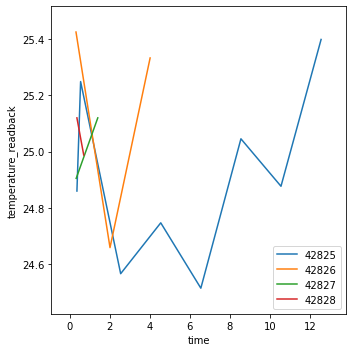

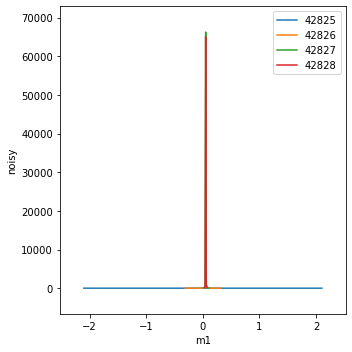

In [4]:
RE(example_findpeak())



Transient Scan ID: 42829     Time: 2021-02-24 21:36:26
Persistent Unique Scan ID: '31599ef3-b2f7-43d4-abea-6e0dc18a65e9'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 21:36:29.4 |   -2.10000 |    0.07446 |
|         2 | 21:36:29.9 |   -1.91000 |    0.08359 |
|         3 | 21:36:30.4 |   -1.72000 |    0.10091 |
|         4 | 21:36:30.9 |   -1.53000 |    0.11824 |
|         5 | 21:36:31.4 |   -1.34000 |    0.14404 |
|         6 | 21:36:31.9 |   -1.15000 |    0.17799 |
|         7 | 21:36:32.4 |   -0.95000 |    0.23655 |
|         8 | 21:36:32.9 |   -0.76000 |    0.31293 |
|         9 | 21:36:33.5 |   -0.57000 |    0.43574 |
|        10 | 21:36:34.0 |   -0.38000 |    0.64777 |
|        11 | 21:36:34.5 |   -0.19000 |    1.01182 |
|        12 | 21:36:35.0 |    0.00000 |    1.96410 |
|  

I Wed-21:36:56 - iterative results:
======= ================== ====================
scan_id center             FWHM                
======= ================== ====================
42829   0.5497880303443519 0.24467200512803222 
42830   0.5025192954957934 0.07002581408618208 
42831   0.500104007441432  0.010794559541161874
42832   0.5001025976616951 0.010604201038850625
======= ================== ====================

I Wed-21:36:56 - Finished #1 of 1 iterations


('31599ef3-b2f7-43d4-abea-6e0dc18a65e9',
 '325d490a-ecdd-45e4-b1bb-e24ec604c709',
 'ef198834-3dc6-4994-a980-e384dc0f18ab',
 'bdd3b7e6-5f50-4bb3-a8e0-ee719a2a33ef')

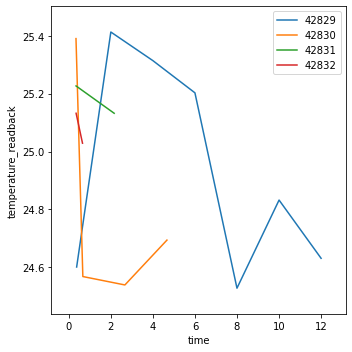

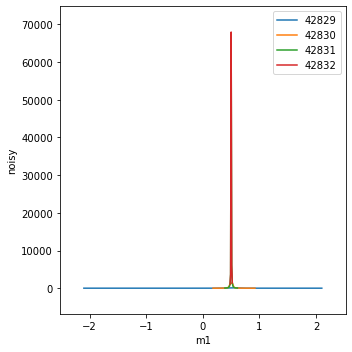

In [5]:
RE(repeat_findpeak())

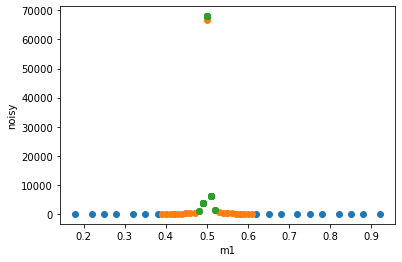

In [6]:
db.v2[-3].primary.read().plot.scatter(x="m1", y="noisy")
db.v2[-2].primary.read().plot.scatter(x="m1", y="noisy")
db.v2[-1].primary.read().plot.scatter(x="m1", y="noisy")

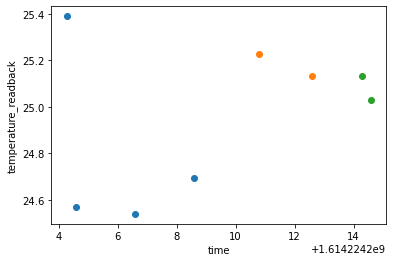

In [7]:
# temperature_monitor
db.v2[-3].temperature_monitor.read().plot.scatter(x="time", y="temperature_readback")
db.v2[-2].temperature_monitor.read().plot.scatter(x="time", y="temperature_readback")
db.v2[-1].temperature_monitor.read().plot.scatter(x="time", y="temperature_readback")